In [46]:
import os
import cv2
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from tensorflow.keras.models import load_model

In [50]:
def load_dataset(base_path, subset):
    subset_path = os.path.join(base_path, subset)
    emotions = os.listdir(subset_path)
    label_map = {emotion: i for i, emotion in enumerate(emotions)}
    images = []
    labels = []

    for emotion, label in label_map.items():
        emotion_path = os.path.join(subset_path, emotion)
        for filename in os.listdir(emotion_path):
            if filename.endswith('.jpg'):
                img_path = os.path.join(emotion_path, filename)
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
                img = cv2.resize(img, (48, 48))
                images.append(img)
                labels.append(label)

    return np.array(images), np.array(labels), label_map

In [57]:
# Usage
base_path = r'D:\Emotion Recognition Project\archive'
train_images, train_labels, label_map = load_dataset(base_path, 'train')
test_images, test_labels, _ = load_dataset(base_path, 'test')

In [58]:
train_images = train_images / 255.0
test_images = test_images / 255.0
train_images = train_images.reshape((-1, 48, 48, 1))
test_images = test_images.reshape((-1, 48, 48, 1))
train_labels = to_categorical(train_labels, num_classes=len(label_map))
test_labels = to_categorical(test_labels, num_classes=len(label_map))

In [59]:
# Create an instance of the ImageDataGenerator with augmentation parameters
data_generator = ImageDataGenerator(
    rotation_range=5,       # Random rotations between -10 to 10 degrees
    width_shift_range=0.1,   # Random horizontal shifts
    height_shift_range=0.1,  # Random vertical shifts
    shear_range=0.1,         # Shear transformations
    zoom_range=0.1,          # Random zoom
    horizontal_flip=True,    # Random horizontal flips
    fill_mode='nearest'      # Strategy for filling newly created pixels
)

In [29]:
model = Sequential([
    Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(64, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, kernel_size=(3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(len(label_map), activation='softmax')
])

In [30]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [31]:
early_stopping = EarlyStopping(
    monitor='val_loss',  # Metric to monitor
    patience=15,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Whether to restore model weights from the epoch with the best value of the monitored quantity
)

In [32]:
data_generator.fit(train_images)

history = model.fit(
    data_generator.flow(train_images, train_labels, batch_size=64),
    epochs=50,
    validation_data=(test_images, test_labels),
    steps_per_epoch=len(train_images) // 64,  # Number of batches per epoch
    callbacks=[early_stopping]
)

Epoch 1/50
448/448 [==============================] - 44s 93ms/step - loss: 1.8272 - accuracy: 0.2391 - val_loss: 1.7879 - val_accuracy: 0.2499
Epoch 2/50
448/448 [==============================] - 43s 95ms/step - loss: 1.7668 - accuracy: 0.2713 - val_loss: 1.7348 - val_accuracy: 0.2948
Epoch 3/50
448/448 [==============================] - 41s 90ms/step - loss: 1.7134 - accuracy: 0.3061 - val_loss: 1.5773 - val_accuracy: 0.3970
Epoch 4/50
448/448 [==============================] - 42s 95ms/step - loss: 1.6358 - accuracy: 0.3506 - val_loss: 1.4687 - val_accuracy: 0.4267
Epoch 5/50
448/448 [==============================] - 36s 81ms/step - loss: 1.5828 - accuracy: 0.3802 - val_loss: 1.4166 - val_accuracy: 0.4536
Epoch 6/50
448/448 [==============================] - 44s 97ms/step - loss: 1.5303 - accuracy: 0.4062 - val_loss: 1.3612 - val_accuracy: 0.4742
Epoch 7/50
448/448 [==============================] - 45s 101ms/step - loss: 1.4992 - accuracy: 0.4206 - val_loss: 1.3400 - val_accuracy

In [35]:
test_loss, test_accuracy = model.evaluate(test_images, test_labels)
print(f'Test accuracy: {test_accuracy}')

225/225 [==============================] - 2s 8ms/step - loss: 1.1276 - accuracy: 0.5690
Test accuracy: 0.5689607262611389


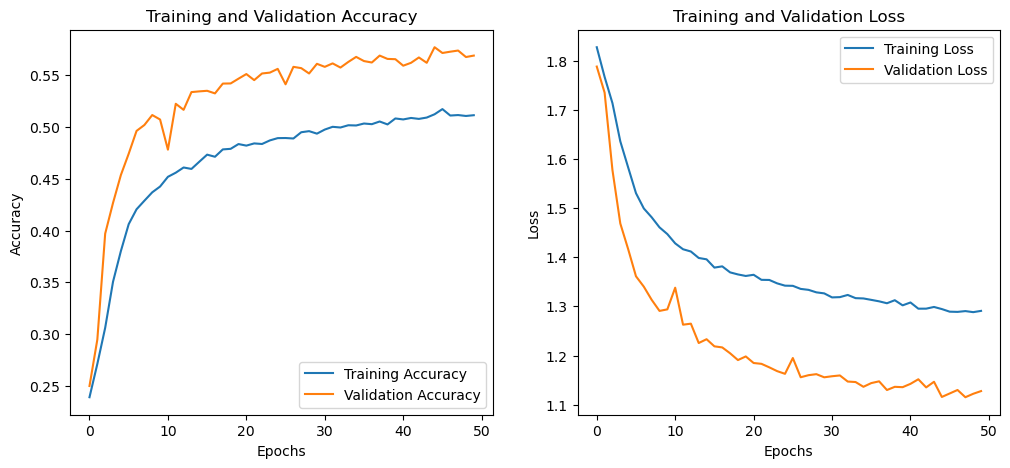

In [36]:

# Plotting training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

# Plotting training and validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

In [37]:
model.save('emotion_detection_model')

INFO:tensorflow:Assets written to: emotion_detection_model\assets


INFO:tensorflow:Assets written to: emotion_detection_model\assets


In [39]:
# Load your trained model
model = load_model('emotion_detection_model')

In [40]:
# Load the image you want to test
image_path = r'D:\Emotion Recognition Project\DallE.png'  # Replace with the path to your image
image = cv2.imread(image_path)
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')

In [41]:
# Detect faces in the image
faces = face_cascade.detectMultiScale(gray_image, scaleFactor=1.1, minNeighbors=5)

In [43]:
reverse_label_map = {v: k for k, v in label_map.items()}

In [44]:
# Assuming that you have at least one face detected, preprocess it
for (x, y, w, h) in faces:
    roi_gray = gray_image[y:y+h, x:x+w]  # Extract the ROI
    roi_gray_resized = cv2.resize(roi_gray, (48, 48))  # Resize to the size your model expects
    roi_gray_normalized = roi_gray_resized / 255.0  # Normalize pixel values as during training
    roi_gray_expanded = np.expand_dims(roi_gray_normalized, axis=0)  # Add batch dimension
    roi_gray_final = np.expand_dims(roi_gray_expanded, axis=3)  # Add channel dimension

    # Make a prediction
    prediction = model.predict(roi_gray_final)
    emotion_label = np.argmax(prediction)
    emotion_name = reverse_label_map[emotion_label]  # Replace with your mapping from labels to emotions

    # Display the result
    cv2.rectangle(image, (x, y), (x+w, y+h), (255, 0, 0), 2)
    cv2.putText(image, emotion_name, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

1/1 [==============================] - 0s 45ms/step


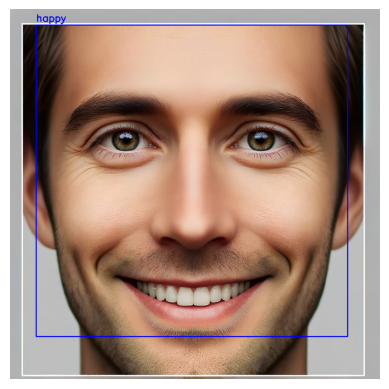

In [45]:

image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image_rgb)
plt.axis('off')  # Turn off axis numbers
plt.show()